# Exponential smoothing sampling

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn.objects as so
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option("mode.copy_on_write", True)
sns.set_theme()

In [2]:
COL_ID = "id"
COL_VAL = "val"
EXP_SMOOTH_ALPHA = 0.3

## Plotting helper functions

In [3]:
COL_COUNT = "count"

def count_values(df, col_target, col_agg_name):
    range_max = 3_000
    range_inc = 100

    return (
        df.assign(val_range=pd.cut(df[COL_VAL], range(0, range_max, range_inc), labels=range(0, range_max - range_inc, range_inc)))
        .groupby(by="val_range", as_index=False, observed=False)
        .agg({col_target: col_agg_name})
        .rename(columns={col_target: COL_COUNT})
    )

def plot_dists(df_orig: pd.DataFrame, df_new: pd.DataFrame):
    df_dups = (
        df_new
        .assign(is_dup=df_new.duplicated(COL_ID))
        .pipe(count_values, "is_dup", "sum")
        .assign(df_name="new_dups")
    )

    df_combined = pd.concat([
        count_values(df_orig, COL_ID, "count").assign(df_name="original"),
        count_values(df_new, COL_ID, "count").assign(df_name="new"),
    ], ignore_index=True)

    _, ax = plt.subplots()
    ax.xaxis.set_tick_params(rotation=45, size=0)

    return (
        so.Plot(df_combined, x="val_range", y=COL_COUNT, color="df_name")
        .add(so.Bars())
        .add(so.Bars(color=".9", width=.5), data=df_dups)
        .on(ax)
    ).show()

## Prepare data

In [4]:
def generate_skewed_dataset(sample_size):
    return pd.DataFrame({
        COL_VAL: np.floor(np.random.exponential(0.3, size=sample_size) * 1000),
        COL_ID: range(0, sample_size)
    }).astype({COL_VAL: int})

In [5]:
df_orig = generate_skewed_dataset(10_000)
df_orig.head()

,val,id
0,72,0
1,11,1
2,363,2
3,349,3
4,887,4


## With Pandas

In [6]:
def exponential_smoothing_sampling(df):
    col_count = "count"
    dict_weight = dict(
        df[COL_VAL]
        .value_counts()
        .reset_index()
        .rename(columns={0: col_count})
        .assign(weight=lambda df_: df_[col_count] ** EXP_SMOOTH_ALPHA / df_[col_count])
        [[COL_VAL, "weight"]]
        .values
    )

    return (df
        .assign(weight=df[COL_VAL].apply(lambda x: dict_weight[x]))
        .sample(len(df), replace=True, weights="weight")
    )

In [7]:
%%time

df_sampled_pd = df_orig.pipe(exponential_smoothing_sampling)

CPU times: user 13.2 ms, sys: 2.41 ms, total: 15.6 ms
Wall time: 14.4 ms


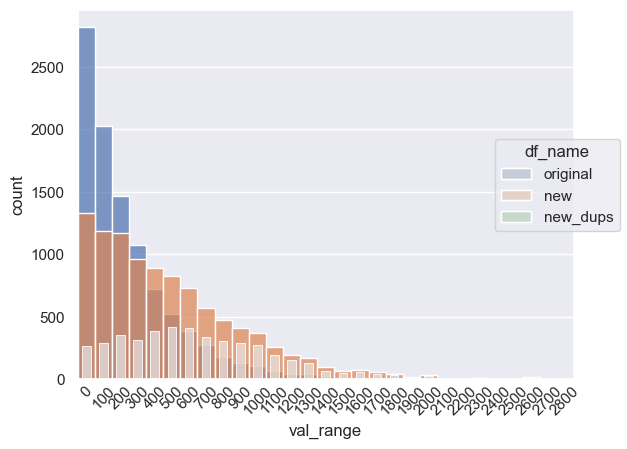

In [8]:
plot_dists(df_orig, df_sampled_pd)

## With Polars

https://github.com/pola-rs/polars/issues/2661
https://github.com/pola-rs/polars/pull/11943

In [9]:
def run_on_polars(df, f, /, *args, **kwargs):
    return (pl.from_pandas(df)
        .lazy()
        .pipe(f, *args, **kwargs)
        .collect()
        .to_pandas()
    )
    
def exponential_smoothing_sampling_w_polars(lf):
    sample_size = lf.select(pl.len()).collect().item()
    
    return (lf
        .pipe(add_probabilities)
        .group_by(COL_VAL)
        .agg([
            pl.col(COL_ID).sample(
                fraction=pl.col("p").first() * sample_size,
                with_replacement=True, seed=1
            )
        ])
        .explode(COL_ID)
        .drop_nulls(COL_ID)
    )

def add_probabilities(lf):
    lf_p = (lf
        .group_by(COL_VAL).len()
        .with_columns(weight=pl.col("len") ** EXP_SMOOTH_ALPHA / pl.col("len"))
        .with_columns(weight_subtotal=pl.col("len") * pl.col("weight"))
        .with_columns(p=pl.col("weight") / pl.col("weight_subtotal").sum())
        .select([COL_VAL, "p"])
    )
    return lf.join(lf_p, on=COL_VAL)

In [10]:
%%time

df_sampled_pl = df_orig.pipe(run_on_polars, exponential_smoothing_sampling_w_polars)

CPU times: user 16.4 ms, sys: 18.3 ms, total: 34.8 ms
Wall time: 13.9 ms


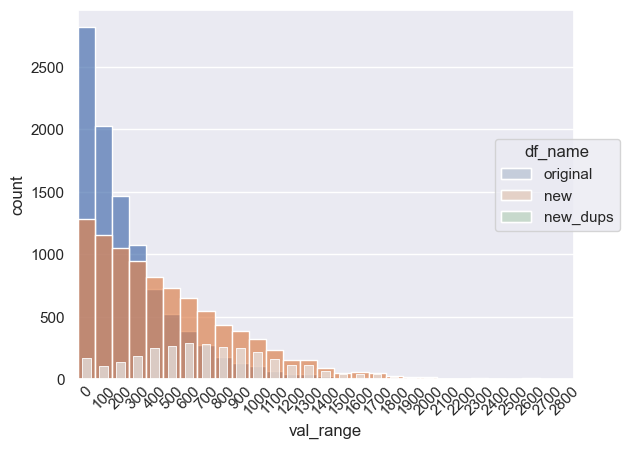

In [11]:
plot_dists(df_orig, df_sampled_pl)

## Now with a bigger dataset

In [12]:
%%time

df_big_orig = generate_skewed_dataset(30_000_000)

CPU times: user 1.12 s, sys: 528 ms, total: 1.65 s
Wall time: 1.78 s


In [13]:
%%time

df_big_sampled_pd = df_big_orig.pipe(exponential_smoothing_sampling)

CPU times: user 50.4 s, sys: 2.29 s, total: 52.7 s
Wall time: 53.4 s


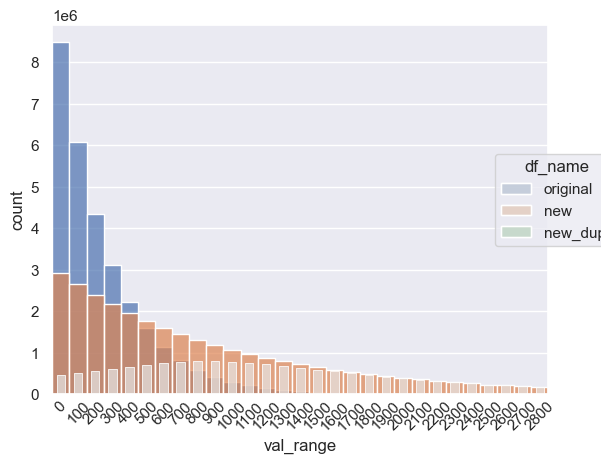

In [14]:
plot_dists(df_big_orig, df_big_sampled_pd)
del df_big_sampled_pd

In [15]:
%%time

df_big_sampled_pl = df_big_orig.pipe(run_on_polars, exponential_smoothing_sampling_w_polars)

CPU times: user 5.05 s, sys: 1.65 s, total: 6.7 s
Wall time: 2.17 s


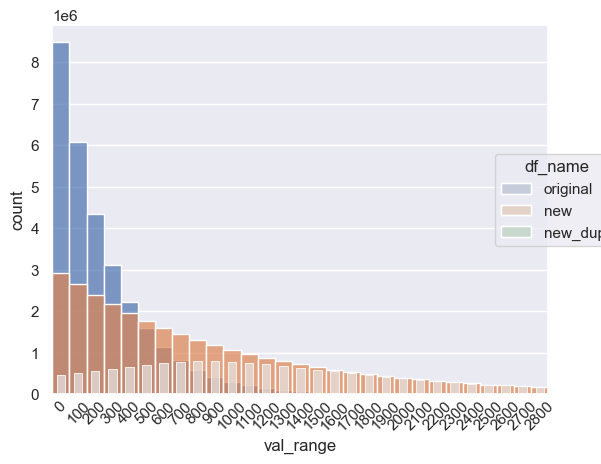

In [16]:
plot_dists(df_big_orig, df_big_sampled_pl)
del df_big_sampled_pl